# Autoencoder Anomaly Detection
Prototype an anomaly detection algorithm using autoencoders. Will be using fashion-MNIST data set. "Hands-On Machine Learning", by Aurelien Geron, is the basis for much of the code. https://github.com/ageron/handson-ml2

In [1]:
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras
import tensorboard

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import shuffle

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

%matplotlib inline

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


## 1.0 Load and Prepare Data

In [59]:
# load fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all, y_train_all), (X_test, y_test) = fashion_mnist.load_data()

# shuffle the data, as a precaution
X_train_all, y_train_all = shuffle(X_train_all, y_train_all, random_state=16)
X_test, y_test = shuffle(X_test, y_test, random_state=16)

# convert all to dtype float32
X_train_all = X_train_all.astype('float32')
X_test = X_test.astype('float32')

In [3]:
# class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
# split the data between train and validation sets, and scale
# also have a "slimmed down" data set that has only positive classes that will be used to train the autoencoder
X_val, X_val_slim, X_train_slim = X_train_all[:5000] / 255.0, \
                                        X_train_all[5000:10000] / 255.0, \
                                        X_train_all[10000:] / 255.0
y_val, y_val_slim, y_train_slim = y_train_all[:5000],y_train_all[5000:10000], y_train_all[10000:]

# also scale the X_test
X_test = X_test / 255.0

print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_val_slim shape:', X_val_slim.shape)
print('y_val_slim shape:', y_val_slim.shape)
print('X_train_slim shape:', X_train_slim.shape)
print('y_train_slim shape:', y_train_slim.shape)

X_val shape: (5000, 28, 28)
y_val shape: (5000,)
X_val_slim shape: (5000, 28, 28)
y_val_slim shape: (5000,)
X_train_slim shape: (50000, 28, 28)
y_train_slim shape: (50000,)


In [5]:
def remove_classes(class_to_remove, y_val_slim, X_val_slim):
    """Funciton to remove classes from train/val set"""
    
    # start with y_valid_slim
    index_to_delete = []
    for i, class_digit in enumerate(y_val_slim):
        if class_digit in class_to_remove:
            index_to_delete.append(i)

    y_val_slim = np.delete(y_val_slim, index_to_delete)
    X_val_slim = np.delete(X_val_slim, index_to_delete, axis=0)
    
    return X_val_slim, y_val_slim

In [6]:
# we will be training the autoencoder on the "normal" class only. All the rest will be labeled as "anomalous"
# this is how anomaly detection is done in Chalapathy R, 2019 https://arxiv.org/pdf/1802.06360.pdf
# I assume this is a good way to do it.... at least I can compare my results to theirs
class_normal = 0
class_to_remove = [i for i in range(0,10)]
class_to_remove.remove(class_normal)
class_to_remove = np.array(class_to_remove,dtype='uint8')


X_val_slim, y_val_slim = remove_classes(class_to_remove, y_val_slim, X_val_slim)
X_train_slim, y_train_slim = remove_classes(class_to_remove, y_train_slim, X_train_slim)

print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_val_slim shape:', X_val_slim.shape)
print('y_val_slim shape:', y_val_slim.shape)
print('X_train_slim shape:', X_train_slim.shape)
print('y_train_slim shape:', y_train_slim.shape)

X_val shape: (5000, 28, 28)
y_val shape: (5000,)
X_val_slim shape: (478, 28, 28)
y_val_slim shape: (478,)
X_train_slim shape: (5011, 28, 28)
y_train_slim shape: (5011,)


In [46]:
# class for data prep
class DataPrep:
    def __init__(self, keras_dataset, class_normal, random_int=16, print_shapes=False):
        
        self.class_normal = class_normal
        self.random_int = random_int
        self.print_shapes = print_shapes

        (X_train_all, y_train_all), (X_test, y_test) = keras_dataset.load_data()

        # shuffle the data, as a precaution
        self.X_train_all, self.y_train_all = shuffle(X_train_all, y_train_all, random_state=random_int)
        self.X_test, self.y_test = shuffle(X_test, y_test, random_state=random_int)

        # convert all to dtype float32
        self.X_train_all = self.X_train_all.astype('float32')
        self.X_test = self.X_test.astype('float32')

    def remove_classes(self, X_val_slim, y_val_slim):
        """Funciton to remove classes from train/val set"""
        
        class_to_remove = [i for i in range(0,10)]
        class_to_remove.remove(self.class_normal)
        class_to_remove = np.array(class_to_remove,dtype='uint8')

        # start with y_valid_slim
        index_to_delete = []
        for i, class_digit in enumerate(y_val_slim):
            if class_digit in class_to_remove:
                index_to_delete.append(i)

        y_val_slim = np.delete(y_val_slim, index_to_delete)
        X_val_slim = np.delete(X_val_slim, index_to_delete, axis=0)

        return X_val_slim, y_val_slim
        
    def train_test_split(self):
        # split the data between train and validation sets, and scale
        # also have a "slimmed down" data set that has only positive classes that will be used to train the autoencoder
        self.X_val, self.X_val_slim, self.X_train = self.X_train_all[:5000] / 255.0, \
                                                self.X_train_all[5000:10000] / 255.0, \
                                                self.X_train_all[10000:] / 255.0
        self.y_val, self.y_val_slim, self.y_train = self.y_train_all[:5000],self.y_train_all[5000:10000], self.y_train_all[10000:]

        # also scale the X_test
        self.X_test = self.X_test / 255.0
        
        self.X_train_slim, self.y_train_slim = self.remove_classes(self.X_train, self.y_train)
        self.X_val_slim, self.y_val_slim = self.remove_classes(self.X_val_slim, self.y_val_slim)
        
        if self.print_shapes == True:
            print('X_val shape:', self.X_val.shape)
            print('y_val shape:', self.y_val.shape)
            print('X_val_slim shape:', self.X_val_slim.shape)
            print('y_val_slim shape:', self.y_val_slim.shape)
            print('X_train shape:', self.X_train.shape)
            print('y_train shape:', self.y_train.shape)
            print('X_train_slim shape:', self.X_train_slim.shape)
            print('y_train_slim shape:', self.y_train_slim.shape)
        
        return (self.X_train, 
                self.y_train, 
                self.X_train_slim, 
                self.y_train_slim, 
                self.X_val,
                self.y_val,
                self.X_val_slim,
                self.y_val_slim,
                self.X_test,
                self.y_test)


In [21]:
class_normal = 0

# class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fashion_mnist = keras.datasets.fashion_mnist
data_model = DataPrep(fashion_mnist,class_normal)

(X_train, y_train, 
 X_train_slim, y_train_slim,
 X_val, y_val,
 X_val_slim, y_val_slim,
 X_test,y_test) = data_model.train_test_split()

X_val shape: (5000, 28, 28)
y_val shape: (5000,)
X_val_slim shape: (478, 28, 28)
y_val_slim shape: (478,)
X_train shape: (50000, 28, 28)
y_train shape: (50000,)
X_train_slim shape: (5011, 28, 28)
y_train_slim shape: (5011,)


## 2.0 Sparse Autoencoder

We will build as sparse autoencoder. But first, we will build a vanilla stacked autoencoder as a comparison.

Andrew Ng has a good video of what a sparse autoencoder is: https://youtu.be/vfnxKO2rMq4

In [5]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Note: we are using sigmoid activations so that the activations all end up between 0 and 1. This will make visualizing the activations easier.

In [6]:
# plot the results
def plot_reconstructions(model, index_list, X_valid): 
    reconstructions = model.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(2, n_images,figsize=(n_images*1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        
    plt.show()

We want to see how the activations behave with this simple stacked autoencoder.
- Using the validation data set, **what is the distribution of activations between 0 and 1?**
- Using the validation data set, **what are the average neuron activation values?**

In [7]:
# build custom regularizer for KL-Divergence
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [38]:
def sparse_kl_model(X_train_slim, X_val_slim, seed=42, epochs=500, earlystop_patience=8):

    tf.random.set_seed(seed)
    np.random.seed(seed)

    kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
    sparse_kl_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
    ])
    sparse_kl_decoder = keras.models.Sequential([
        keras.layers.Dense(100, activation="selu", input_shape=[300]),
        keras.layers.Dense(28 * 28, activation="sigmoid"),
        keras.layers.Reshape([28, 28])
    ])
    sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
    sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(),
                  metrics=[rounded_accuracy])

    # show summary, if wanted
    # sparse_kl_encoder.summary()
    # sparse_kl_decoder.summary()

    # use tensorboard to track training
    log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                          histogram_freq=0,
                                                          update_freq='epoch',
                                                          profile_batch=0)

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=8, 
                                                          restore_best_weights=True)

    history = sparse_kl_ae.fit(X_train_slim, X_train_slim, epochs=epochs,
                               validation_data=[X_val_slim, X_val_slim], 
                               callbacks=[tensorboard_callback,earlystop_callback],verbose=0)
    return sparse_kl_ae

In [9]:
sparse_kl_ae = sparse_kl_model(X_train_slim, X_val_slim, seed=42, epochs=500)

Train on 5011 samples, validate on 478 samples
Epoch 1/500
5011/5011 [==============================] - 2s 306us/sample - loss: 0.4350 - rounded_accuracy: 0.8408 - val_loss: 0.3804 - val_rounded_accuracy: 0.8890
Epoch 2/500
5011/5011 [==============================] - 0s 93us/sample - loss: 0.3689 - rounded_accuracy: 0.8965 - val_loss: 0.3678 - val_rounded_accuracy: 0.8965
Epoch 3/500
5011/5011 [==============================] - 0s 94us/sample - loss: 0.3574 - rounded_accuracy: 0.9042 - val_loss: 0.3581 - val_rounded_accuracy: 0.9026
Epoch 4/500
5011/5011 [==============================] - 0s 95us/sample - loss: 0.3500 - rounded_accuracy: 0.9089 - val_loss: 0.3549 - val_rounded_accuracy: 0.9046
Epoch 5/500
5011/5011 [==============================] - 0s 92us/sample - loss: 0.3468 - rounded_accuracy: 0.9117 - val_loss: 0.3511 - val_rounded_accuracy: 0.9076
Epoch 6/500
5011/5011 [==============================] - 0s 94us/sample - loss: 0.3419 - rounded_accuracy: 0.9171 - val_loss: 0.3455

5011/5011 [==============================] - 0s 89us/sample - loss: 0.3113 - rounded_accuracy: 0.9525 - val_loss: 0.3180 - val_rounded_accuracy: 0.9478
Epoch 50/500
5011/5011 [==============================] - 0s 91us/sample - loss: 0.3110 - rounded_accuracy: 0.9529 - val_loss: 0.3175 - val_rounded_accuracy: 0.9480
Epoch 51/500
5011/5011 [==============================] - 0s 91us/sample - loss: 0.3109 - rounded_accuracy: 0.9531 - val_loss: 0.3176 - val_rounded_accuracy: 0.9486
Epoch 52/500
5011/5011 [==============================] - 0s 89us/sample - loss: 0.3108 - rounded_accuracy: 0.9531 - val_loss: 0.3176 - val_rounded_accuracy: 0.9473
Epoch 53/500
5011/5011 [==============================] - 0s 92us/sample - loss: 0.3107 - rounded_accuracy: 0.9532 - val_loss: 0.3171 - val_rounded_accuracy: 0.9486
Epoch 54/500
5011/5011 [==============================] - 0s 92us/sample - loss: 0.3103 - rounded_accuracy: 0.9536 - val_loss: 0.3170 - val_rounded_accuracy: 0.9488
Epoch 55/500
5011/5011 

Epoch 99/500
5011/5011 [==============================] - 0s 89us/sample - loss: 0.3064 - rounded_accuracy: 0.9590 - val_loss: 0.3139 - val_rounded_accuracy: 0.9529
Epoch 100/500
5011/5011 [==============================] - 0s 98us/sample - loss: 0.3064 - rounded_accuracy: 0.9592 - val_loss: 0.3139 - val_rounded_accuracy: 0.9530
Epoch 101/500
5011/5011 [==============================] - 0s 89us/sample - loss: 0.3062 - rounded_accuracy: 0.9592 - val_loss: 0.3136 - val_rounded_accuracy: 0.9529
Epoch 102/500
5011/5011 [==============================] - 0s 91us/sample - loss: 0.3062 - rounded_accuracy: 0.9593 - val_loss: 0.3138 - val_rounded_accuracy: 0.9525
Epoch 103/500
5011/5011 [==============================] - 0s 91us/sample - loss: 0.3062 - rounded_accuracy: 0.9593 - val_loss: 0.3137 - val_rounded_accuracy: 0.9529
Epoch 104/500
5011/5011 [==============================] - 0s 90us/sample - loss: 0.3061 - rounded_accuracy: 0.9594 - val_loss: 0.3135 - val_rounded_accuracy: 0.9530
Epoch

5011/5011 [==============================] - 0s 90us/sample - loss: 0.3046 - rounded_accuracy: 0.9617 - val_loss: 0.3125 - val_rounded_accuracy: 0.9544
Epoch 149/500
5011/5011 [==============================] - 0s 90us/sample - loss: 0.3046 - rounded_accuracy: 0.9616 - val_loss: 0.3124 - val_rounded_accuracy: 0.9553
Epoch 150/500
5011/5011 [==============================] - 0s 96us/sample - loss: 0.3045 - rounded_accuracy: 0.9618 - val_loss: 0.3126 - val_rounded_accuracy: 0.9549
Epoch 151/500
5011/5011 [==============================] - 0s 90us/sample - loss: 0.3045 - rounded_accuracy: 0.9617 - val_loss: 0.3123 - val_rounded_accuracy: 0.9551
Epoch 152/500
5011/5011 [==============================] - 0s 89us/sample - loss: 0.3044 - rounded_accuracy: 0.9619 - val_loss: 0.3124 - val_rounded_accuracy: 0.9551
Epoch 153/500
5011/5011 [==============================] - 0s 91us/sample - loss: 0.3044 - rounded_accuracy: 0.9619 - val_loss: 0.3124 - val_rounded_accuracy: 0.9551
Epoch 154/500
5011

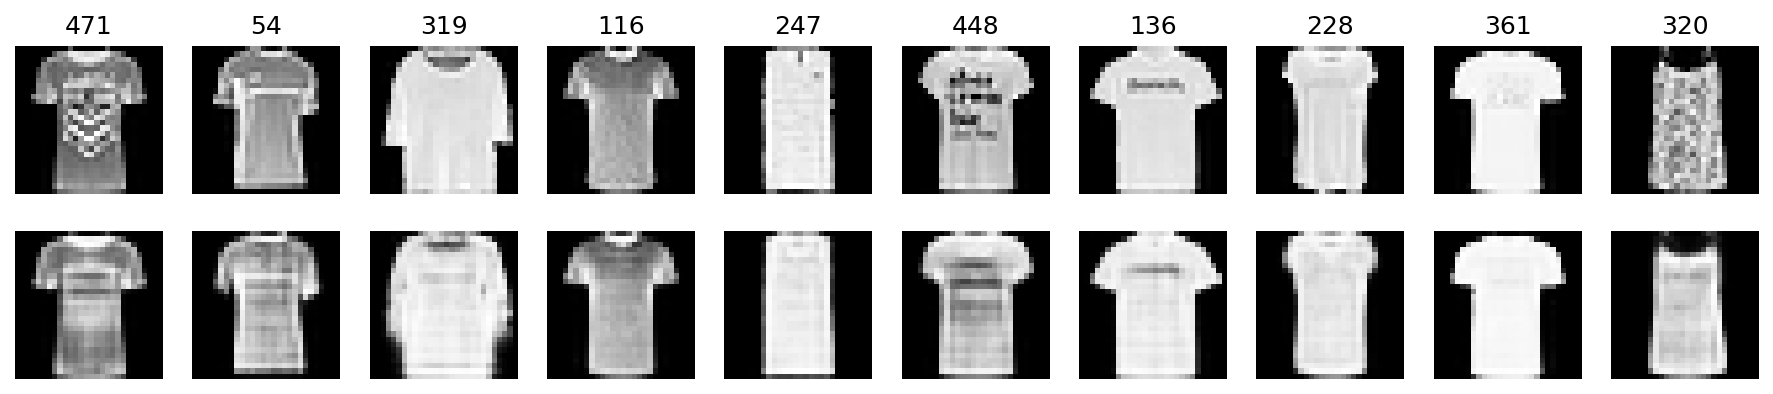

In [10]:
# plot a random number of items
import random
index_list = random.sample(range(0,len(X_val_slim)), 10)

plot_reconstructions(sparse_kl_ae, index_list, X_val_slim)

In [47]:
class SelectThreshold:
    
    def __init__(self, model, X_val, y_val, X_val_slim, class_to_remove, class_normal, class_names):
        
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        self.X_val_slim = X_val_slim
        self.class_to_remove = class_to_remove
        self.class_normal = class_normal
        self.class_names = class_names
        
        print(np.shape(self.X_val))
        
        # build the reconstructions on the X_val_slim dataset, and the X_val dataset
        self.recon_val_slim = self.model(self.X_val_slim).numpy()
        self.recon_val = self.model(self.X_val).numpy()
        
    def mse(self, X_val, recon_val):
        """Calculate MSE for images in X_val and recon_val"""
        # need to calculate mean across the rows, and then across the columns
        return np.mean(np.mean(np.square(X_val - recon_val),axis=1),axis=1)

    def rmse(self, X_val, recon_val):
        """Calculate RMSE for images in X_val and recon_val"""
        return np.sqrt(self.mse(X_val, recon_val))

    def euclidean_distance(self, X_val, recon_val):
        dist = np.linalg.norm(X_val - recon_val,axis=(1,2))
        return dist
    
    # function that creates a pandas dataframe with the RMSE value, and the associated class
    def create_df_reconstruction(self, reconstruction_error_val, threshold_val):
        df = pd.DataFrame(data=reconstruction_error_val, columns=["metric"])

        class_names_list = list(zip(self.class_names, range(len(self.class_names))))
        
        y_names = []
        for i in self.y_val:
            y_names.append(str(i)+", "+class_names_list[i][0])
        
        # append the class values
        df['class'] = self.y_val
        df['class_names'] = y_names

        # label anomolous (outlier) data as -1, inliers as 1
            # -1 (outlier) is POSITIVE class
            #  1 (inlier) is NEGATIVE class
        new_y_val = []
        for i in self.y_val:
            if i in class_to_remove:
                new_y_val.append(-1)
            else:
                new_y_val.append(1)

        df['true_class'] = new_y_val

        # add prediction based on threshold
        df['prediction'] = np.where(df['metric'] >= threshold_val,-1,1)

        return df
    
    def threshold_grid_search(self, lower_bound, upper_bound, reconstruction_error_val, grid_iterations=10):
        '''Simple grid search for finding the best threshold'''
    
        roc_scores = {}
        grid_search_count = 0
        for i in np.arange(lower_bound, upper_bound, (np.abs(upper_bound-lower_bound) / grid_iterations)):
#             if grid_search_count%50 == 0:
#                 print('grid search iteration: ', grid_search_count)

            threshold_val = i
            df = self.create_df_reconstruction(reconstruction_error_val, 
                                          threshold_val)
            roc_val = roc_auc_score(df['true_class'], df['prediction'])
            roc_scores[i] = roc_val
            grid_search_count += 1

        # return best roc_score and the threshold used to set it
        threshold_val = max(zip(roc_scores.values(), roc_scores.keys()))
        best_threshold = threshold_val[1]
        best_roc_score = threshold_val[0]
        print('Best threshold value:', best_threshold,'\tROC score: {:.2%}'.format(best_roc_score))

        # use the best threshold value to make a confusion matrix
        df = self.create_df_reconstruction(reconstruction_error_val, best_threshold)
        
        return df, best_threshold, best_roc_score
    
    def box_plot(self, df, best_threshold, best_roc_score, metric):
        fig, ax = plt.subplots(figsize=(12,5))
        df.boxplot(column=['metric'], by='class_names', ax=ax).axhline(y=best_threshold,c='red',alpha=0.7)
        plt.title('Boxplots of {} for X_valid, by Class'.format(metric))
        plt.suptitle('')
        plt.show()
        
#         print('\nConfusion Matrix:')
#         print(confusion_matrix(df['true_class'], df['prediction']))
        
    # function to test the different reconstruction methods (mse, rmse, euclidean)
    # do a grid search looking for the best threshold, and then outputting the results
    def compare_error_method(self,show_results=True, grid_iterations=10):
        '''Function to test the different reconstruction methods (mse, rmse, euclidean) 

        Parameters
        ===========
        model : tensorflow model
            autoencoder model that was trained on the "slim" data set.
            Will be used to build reconstructions

        X_val : ndarray
            tensor of the X validation set

        class_to_remove : ndarray
            numpy array of the classes to remove from the X_val and y_val data
        '''
        
        col = ['class_normal','method','best_threshold','best_roc_score']
        result_table = pd.DataFrame(columns=col)
        
        # build the reconstructions on the X_val_slim dataset, and the X_val dataset
        recon_val_slim = self.model(self.X_val_slim).numpy()
        recon_val = self.model(self.X_val).numpy()

        # run through each of the reconstruction error methods, perform a little grid search
        # to find the optimum value

        #_______MSE_______#
        # calculate MSE reconstruction error
        mse_recon_val_slim = self.mse(self.X_val_slim, recon_val_slim) # for slim dataset
        mse_recon_val = self.mse(self.X_val, recon_val) # for complete validation dataset
        
        max_mse = np.max(mse_recon_val_slim)
        percentile_mse = np.percentile(mse_recon_val_slim,90)
#         print('Max MSE on val_slim:\t\t\t',max_mse)
#         print('90th MSE percentile on val_slim:\t', percentile_mse)

        lower_bound = percentile_mse - percentile_mse*0.9
        upper_bound = max_mse*1.5

        df, best_threshold, best_roc_score = self.threshold_grid_search(lower_bound,
                                                                                upper_bound,
                                                                                mse_recon_val,grid_iterations)
        result_table = result_table.append(pd.DataFrame([[self.class_normal,'mse',
                                                          best_threshold, 
                                                          best_roc_score]],
                                                        columns=col))
        
        if show_results == True:
            self.box_plot(df, best_threshold, best_roc_score, 'MSE')
        
        #_______RMSE_______#
        # calculate RMSE reconstruction error
        rmse_recon_val_slim = self.rmse(self.X_val_slim, recon_val_slim) # for slim dataset
        rmse_recon_val = self.rmse(self.X_val, recon_val) # for complete validation dataset
        
        max_rmse = np.max(rmse_recon_val_slim)
        percentile_rmse = np.percentile(rmse_recon_val_slim,90)
#         print('Max RMSE on val_slim:\t\t\t',max_rmse)
#         print('90th RMSE percentile on val_slim:\t', percentile_rmse)

        lower_bound = percentile_rmse - percentile_rmse*0.9
        upper_bound = max_rmse*1.5

        df, best_threshold, best_roc_score = self.threshold_grid_search(lower_bound,
                                                                                upper_bound,
                                                                                rmse_recon_val,grid_iterations)
        
        result_table = result_table.append(pd.DataFrame([[self.class_normal,'rmse',
                                                  best_threshold, 
                                                  best_roc_score]],
                                                columns=col))
        
        if show_results == True:
            self.box_plot(df, best_threshold, best_roc_score, 'RMSE')
        
        #_______Euclidean_______#
        # calculate Euclidean reconstruction error
        eu_recon_val_slim = self.euclidean_distance(self.X_val_slim, recon_val_slim) # for slim dataset
        eu_recon_val = self.euclidean_distance(self.X_val, recon_val) # for complete validation dataset
        
        max_eu = np.max(eu_recon_val_slim)
        percentile_eu = np.percentile(eu_recon_val_slim,90)
#         print('Max Euc. on val_slim:\t\t\t',max_eu)
#         print('90th Euc. percentile on val_slim:\t', percentile_eu)

        lower_bound = percentile_eu - percentile_eu*0.9
        upper_bound = max_eu*1.5

        df, best_threshold, best_roc_score = self.threshold_grid_search(lower_bound,
                                                                      upper_bound, 
                                                                      eu_recon_val,grid_iterations)
        
        result_table = result_table.append(pd.DataFrame([[self.class_normal,'euclid_dist',
                                          best_threshold, 
                                          best_roc_score]],
                                        columns=col))
        if show_results == True:
            self.box_plot(df, best_threshold, best_roc_score, 'Euclidean Distance')
        
        return result_table

In [19]:
class_to_remove = [i for i in range(0,10)]
class_to_remove.remove(class_normal)
class_to_remove = np.array(class_to_remove,dtype='uint8')

model = SelectThreshold(sparse_kl_ae, X_val, y_val, X_val_slim, class_to_remove, class_normal, class_names)
# model = SelectThreshold(sparse_kl_ae, X_train, y_train, X_train_slim, class_to_remove, class_normal, class_names)

(5000, 28, 28)


In [20]:
df = model.compare_error_method(show_results=False, grid_iterations=200)

Best threshold value: 0.006637242125859484 	ROC score: 84.16%
Best threshold value: 0.08192944648303088 	ROC score: 84.20%
Best threshold value: 2.2940245608091363 	ROC score: 84.20%


In [14]:
df

,class_normal,method,best_threshold,best_roc_score
0,0,mse,0.007413,0.865276
0,0,rmse,0.087005,0.865346
0,0,euclid_dist,2.436133,0.865346


## Test Multiple Classes

In [28]:
import random
random.randint(0,250)

74

In [ ]:
col = ['class_normal','method','best_threshold','best_roc_score']
df_all = pd.DataFrame(columns=col)
fashion_mnist = keras.datasets.fashion_mnist
run_no = 1
for class_normal in range(0,10):
    for i in range(0,50):
        print('Run no: ', run_no, ' Class: ', class_normal)
        # load data
    #     class_normal = 0

        # class names
        class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                       "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
        random_int = random.randint(0,500)
        print('Random seed: ',random_int)
        
        data_model = DataPrep(fashion_mnist,class_normal, random_int=random_int)

        (X_train, y_train, 
         X_train_slim, y_train_slim,
         X_val, y_val,
         X_val_slim, y_val_slim,
         X_test,y_test) = data_model.train_test_split()

        sparse_kl_ae = sparse_kl_model(X_train_slim, X_val_slim, seed=random_int, epochs=500, earlystop_patience=8)

        class_to_remove = [i for i in range(0,10)]
        class_to_remove.remove(class_normal)
        class_to_remove = np.array(class_to_remove,dtype='uint8')

        model = SelectThreshold(sparse_kl_ae, X_val, y_val, X_val_slim, class_to_remove, class_normal, class_names)
        df = model.compare_error_method(show_results=False, grid_iterations=200)

        df_all = df_all.append(df)
        
        run_no += 1

Run no:  1  Class:  0
Random seed:  71
(5000, 28, 28)
Best threshold value: 0.0065968783884309224 	ROC score: 84.09%
Best threshold value: 0.08177399586886165 	ROC score: 84.14%
Best threshold value: 2.289671823978425 	ROC score: 84.14%
Run no:  2  Class:  0
Random seed:  184
(5000, 28, 28)
Best threshold value: 0.013608068773895506 	ROC score: 83.13%
Best threshold value: 0.11752103378176687 	ROC score: 83.27%
Best threshold value: 3.2905889932632455 	ROC score: 83.27%
Run no:  3  Class:  0
Random seed:  107
(5000, 28, 28)
Best threshold value: 0.011503378015011547 	ROC score: 83.46%
Best threshold value: 0.10643526479601857 	ROC score: 83.62%
Best threshold value: 2.9801875090599053 	ROC score: 83.62%
Run no:  4  Class:  0
Random seed:  178
(5000, 28, 28)
Best threshold value: 0.006547336642909795 	ROC score: 83.03%
Best threshold value: 0.0808097416341305 	ROC score: 82.95%
Best threshold value: 2.262672771644592 	ROC score: 82.95%
Run no:  5  Class:  0
Random seed:  238


In [53]:
df_all

,class_normal,method,best_threshold,best_roc_score
0,0,mse,0.007573,0.812847
0,0,rmse,0.086789,0.812766
0,0,euclid_dist,2.430096,0.812766
0,0,mse,0.009364,0.827905
0,0,rmse,0.098628,0.827165
...,...,...,...,...
0,5,rmse,0.144601,0.864985
0,5,euclid_dist,4.048823,0.864985
0,5,mse,0.019646,0.866845
0,5,rmse,0.139970,0.866845


In [54]:
df_all.to_csv('sparse_kl_ae_2.csv')

In [62]:
df1=df_all.groupby(['class_normal', 'method']).mean()
df1.reset_index(inplace=True)
df1

,class_normal,method,best_threshold,best_roc_score
0,0,euclid_dist,2.418287,0.821945
1,0,mse,0.007649,0.821697
2,0,rmse,0.086367,0.821945
3,1,euclid_dist,2.238191,0.954852
4,1,mse,0.006453,0.954933
5,1,rmse,0.079935,0.954852
6,2,euclid_dist,2.466501,0.799280
7,2,mse,0.007972,0.799023
8,2,rmse,0.088089,0.799280
9,3,euclid_dist,2.425930,0.839486


In [86]:
df2 = df_all[df_all['method']=='rmse']
df2=df2.groupby(['class_normal']).mean()
df2.reset_index(inplace=True)
df2

,class_normal,best_threshold,best_roc_score
0,0,0.086367,0.821945
1,1,0.079935,0.954852
2,2,0.088089,0.799280
3,3,0.086640,0.839486
4,4,0.091545,0.826269
5,5,0.139933,0.868163


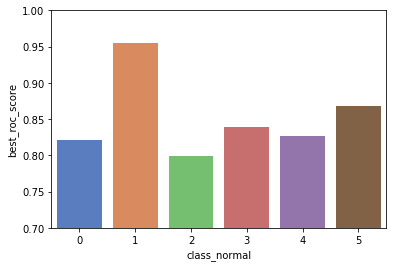

In [89]:
import seaborn as sns
sns.barplot(x='class_normal', y='best_roc_score', data=df2,palette="muted")
plt.ylim(0.7, 1.0)
plt.show()

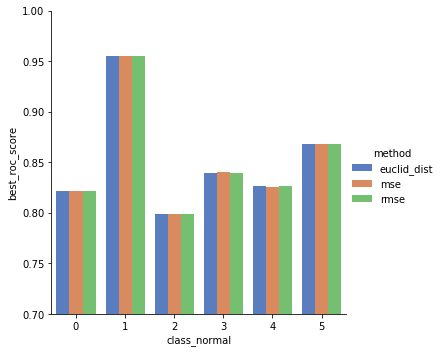

In [74]:
sns.catplot(x='class_normal', y='best_roc_score', hue='method', data=df1, kind='bar',palette="muted")
plt.ylim(0.7, 1.0)
plt.show()

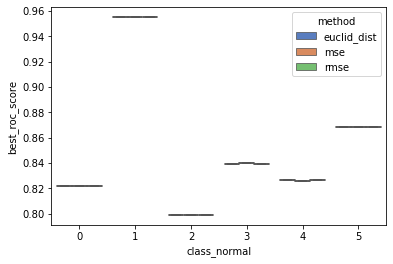

In [70]:
sns.boxplot(x='class_normal', y='best_roc_score', hue='method', data=df1,palette="muted")